## Problem Statement:
---
I am working as a data science consultant for a large organization. They have been contracted by a realty company interested in gaining a data advantage in the world of home buying. Their current business model prioritizes the acquisition of newer properties in desirable locations, that possess the highest inspector ratings. This is both due to their value and the likelihood of these houses requiring less expense in maintenance and remodelling. Seeking to clarify the effectiveness of their business model, they have posed my organization some clarifying questions, as well as a request for a predictive algorithm that they can utilize going forward to forecast the likely selling prices of new homes coming on the market. 

- Key questions to answer, according to their business model:
  - What is the average selling price all homes?
  - Do newer houses (those less than 50 years old) sell significantly higher than the average price?
  - Do newer houses sell significanlty higher than older houses? *If they don't, this could be evidence that some other factor other than the age of a home is contributing to property pricing.*
  - If all these prove true - what is the average selling price of newer homes?
  - How does the overall ranking of a home affect the sale price?
  - How does the location of a home (in terms of its neighborhood) affect the price of a home?

I am specifically tasked with getting this information on behalf of our client, and reporting my findings to my project manager.

**My strategy for accomplishing this task:** Utilizing white box preditive models carries with it the benefit of interpretability of data. After conducting an analysis of primary factors, I will use two models - one simple model, focused on interpretable results to describe effects of key factors, and another that focuses primarily on optimal preditive power with minimal error.

From opendoor.com, [8 Critical Factors that Influence a Home's Value](https://www.opendoor.com/w/blog/factors-that-influence-home-value), it is indicated that location, size, and age, are three of the top factors, consistent with their business model. While I cannot look at nearby ammenities (such as schools or grocery stores) in this dataset, I can generally look at the neighborhoods themselves, to see how value interacts with their location.

### Import packages and read in the data
---

In [3]:
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib.pyplot as plt
import seaborn as sns
import stat_functions as st
import missingno
from scipy.stats import ttest_ind, norm, t, chisquare, chi2
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PowerTransformer

In [4]:
pd.options.display.max_columns = 100
pd.options.display.max_columns = 3000

This is for later. Found on [this stackoverflow thread](https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set) and [this documentation](https://scikit-learn.org/stable/modules/generated/sklearn.compose.make_column_transformer.html) about how to scale only specific columns on your data!

In [5]:
from sklearn.compose import ColumnTransformer, make_column_transformer

In [6]:
train_data = pd.read_csv('datasets/train.csv')
test_data = pd.read_csv('datasets/test.csv')
sample_submission = pd.read_csv('datasets/sample_sub_reg.csv')

In [7]:
train_data.shape

(2051, 81)

In [8]:
train_data.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Roof Style,Roof Matl,Exterior 1st,Exterior 2nd,Mas Vnr Type,Mas Vnr Area,Exter Qual,Exter Cond,Foundation,Bsmt Qual,Bsmt Cond,Bsmt Exposure,BsmtFin Type 1,BsmtFin SF 1,BsmtFin Type 2,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,Heating,Heating QC,Central Air,Electrical,1st Flr SF,2nd Flr SF,Low Qual Fin SF,Gr Liv Area,Bsmt Full Bath,Bsmt Half Bath,Full Bath,Half Bath,Bedroom AbvGr,Kitchen AbvGr,Kitchen Qual,TotRms AbvGrd,Functional,Fireplaces,Fireplace Qu,Garage Type,Garage Yr Blt,Garage Finish,Garage Cars,Garage Area,Garage Qual,Garage Cond,Paved Drive,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,NaN,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,NaN,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,NaN,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,NaN,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


## Data Cleaning
---

In [9]:
train_data.drop(columns = 'PID', inplace = True)
test_data.drop(columns = 'PID', inplace = True)

In [10]:
train_data['Lot Frontage'].sort_values(ascending = True) #Looks like if the street doesn't connect to the home
#directly, a NaN instead of a 0 is entered. Let's fix that. 

53      21.0
1534    21.0
787     21.0
796     21.0
1834    21.0
        ... 
2016     NaN
2022     NaN
2028     NaN
2031     NaN
2047     NaN
Name: Lot Frontage, Length: 2051, dtype: float64

Notes from [the data dictionary](http://jse.amstat.org/v19n3/decock/DataDocumentation.txt) on some other NANs to fill. These "NaN" values are not really empty! 

- Alley is NaN when there is no alley access (rename)
- Mas Vnr Type (Masonry Veneer Type) None is not empty - it is 'No Veneer Type'
- Bsmt Qual evaluates the height of the basement. NaN values mean 'No Basement,' not empty values.
- BsmtFin Type 1 likewise means 'No Basement' as a quality evaluation.
- BsmtFin Type 2 same
- FireplaceQu which evaluates quality of fireplaces - NaN means "No fireplace."
- Garage Type, Garage Finish ,Garage Qual, and Garage Cond evaluates the value of garage types - NaN means 'No garage.'
- Pool QC evaluates quality of a pool. Nan means 'No pool.'
- Fence evaluates fence quality. NaN means "No fence."
- Misc Feature captures any last features. NaN means 'no additional features.'

The filling of NaN values could get repetetive, so I will make a generalized function that will handle this for me.

**ANY COLUMN/VALUE CHANGES IN TRAIN MUST BE IN TEST OR THE MODEL WILL NOT PREDICT**

In [11]:
null_col_list = train_data.columns[train_data.isnull().any()]
null_col_list #Note Garage Yr Blt. I will treat this one column a little differently

Index(['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type',
       'Garage Yr Blt', 'Garage Finish', 'Garage Cars', 'Garage Area',
       'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature'],
      dtype='object')

In [12]:
null_col_list = ['Lot Frontage', 'Alley', 'Mas Vnr Type', 'Mas Vnr Area', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Bsmt Full Bath', 'Bsmt Half Bath', 'Fireplace Qu', 'Garage Type',
        'Garage Finish', 'Garage Cars', 'Garage Area',
       'Garage Qual', 'Garage Cond', 'Pool QC', 'Fence', 'Misc Feature']

In [13]:
data_dtype = [train_data[col].dtype for col in null_col_list]

In [14]:
null_list_types = {name:dattype for name, dattype in zip(null_col_list, data_dtype)} #Just for me to keep track

In [15]:
null_val_list = [0, 'No alley access', 'None', 0, 'No Basement', 'No Basement',
                'No Basement','No Basement', 0, 'No Basement', 0, 0, 0, 0, 0, 'No Fireplace', 'No Garage',
                'No Garage',0, 0, 'No Garage', 'No Garage',
                 'No Pool', 'No Fence', 'No Misc Features']

In [16]:
#Writing a function that will quickly append these values when NaNs are present in my dataset.

def fill_nans(list_names, list_values):
    for name,value in zip(list_names, list_values):
        train_data[name].fillna(value, inplace = True)
        test_data[name].fillna(value, inplace = True)

In [17]:
fill_nans(null_col_list, null_val_list)

In [18]:
#For this one, I'm going to set the year built to the year of remodel/add, as that is year the residence
# was built, or most recent renovate year. I know these values had no garages, but inserting a year of 0 would
# be far more damaging to predictive models if I intend to use years as a feature.

train_data['Garage Yr Blt'] = train_data.apply(lambda row:row['Year Remod/Add'] if 
                                              pd.isnull(row['Garage Yr Blt']) else row['Garage Yr Blt'],
                                              axis = 1)

test_data['Garage Yr Blt'] = test_data.apply(lambda row:row['Year Remod/Add'] if 
                                              pd.isnull(row['Garage Yr Blt']) else row['Garage Yr Blt'],
                                              axis = 1)

In [19]:
#Calling null_col_list again to ensure no more NaN values in my columns.
null_col_list = train_data.columns[train_data.isnull().any()]
null_col_list #We're good, the list is empty.

Index([], dtype='object')

A little more cleaning of asthetics for future work.

In [20]:
#properly name columns
train_data.rename(columns = {col:col.lower() for col in train_data.columns}, inplace = True)
test_data.rename(columns = {col:col.lower() for col in test_data.columns}, inplace = True)

In [21]:
train_data.rename(columns = {col:col.replace(' ', '_') for col in 
                                    train_data.columns}, inplace = True)
test_data.rename(columns = {col:col.replace(' ', '_') for col in 
                                    test_data.columns}, inplace = True)

In [22]:
test_data.head()

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type
0,2658,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,2fmCon,2Story,6,8,1910,1950,Gable,CompShg,AsbShng,AsbShng,None,0.0,TA,Fa,Stone,Fa,TA,No,Unf,0,Unf,0,1020,1020,GasA,Gd,N,FuseP,908,1020,0,1928,0,0,2,0,4,2,Fa,9,Typ,0,No Fireplace,Detchd,1910.0,Unf,1,440,Po,Po,Y,0,60,112,0,0,0,No Pool,No Fence,No Misc Features,0,4,2006,WD
1,2718,90,RL,0.0,9662,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,Duplex,1Story,5,4,1977,1977,Gable,CompShg,Plywood,Plywood,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,1967,1967,GasA,TA,Y,SBrkr,1967,0,0,1967,0,0,2,0,6,2,TA,10,Typ,0,No Fireplace,Attchd,1977.0,Fin,2,580,TA,TA,Y,170,0,0,0,0,0,No Pool,No Fence,No Misc Features,0,8,2006,WD
2,2414,60,RL,58.0,17104,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,7,5,2006,2006,Gable,CompShg,VinylSd,VinylSd,None,0.0,Gd,TA,PConc,Gd,Gd,Av,GLQ,554,Unf,0,100,654,GasA,Ex,Y,SBrkr,664,832,0,1496,1,0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,2006.0,RFn,2,426,TA,TA,Y,100,24,0,0,0,0,No Pool,No Fence,No Misc Features,0,9,2006,New
3,1989,30,RM,60.0,8520,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Norm,Norm,1Fam,1Story,5,6,1923,2006,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,Gd,TA,CBlock,TA,TA,No,Unf,0,Unf,0,968,968,GasA,TA,Y,SBrkr,968,0,0,968,0,0,1,0,2,1,TA,5,Typ,0,No Fireplace,Detchd,1935.0,Unf,2,480,Fa,TA,N,0,0,184,0,0,0,No Pool,No Fence,No Misc Features,0,7,2007,WD
4,625,20,RL,0.0,9500,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,5,1963,1963,Gable,CompShg,Plywood,Plywood,BrkFace,247.0,TA,TA,CBlock,Gd,TA,No,BLQ,609,Unf,0,785,1394,GasA,Gd,Y,SBrkr,1394,0,0,1394,1,0,1,1,3,1,TA,6,Typ,2,Gd,Attchd,1963.0,RFn,2,514,TA,TA,Y,0,76,0,0,185,0,No Pool,No Fence,No Misc Features,0,7,2009,WD


In [23]:
train_data.head()

,id,ms_subclass,ms_zoning,lot_frontage,lot_area,street,alley,lot_shape,land_contour,utilities,lot_config,land_slope,neighborhood,condition_1,condition_2,bldg_type,house_style,overall_qual,overall_cond,year_built,year_remod/add,roof_style,roof_matl,exterior_1st,exterior_2nd,mas_vnr_type,mas_vnr_area,exter_qual,exter_cond,foundation,bsmt_qual,bsmt_cond,bsmt_exposure,bsmtfin_type_1,bsmtfin_sf_1,bsmtfin_type_2,bsmtfin_sf_2,bsmt_unf_sf,total_bsmt_sf,heating,heating_qc,central_air,electrical,1st_flr_sf,2nd_flr_sf,low_qual_fin_sf,gr_liv_area,bsmt_full_bath,bsmt_half_bath,full_bath,half_bath,bedroom_abvgr,kitchen_abvgr,kitchen_qual,totrms_abvgrd,functional,fireplaces,fireplace_qu,garage_type,garage_yr_blt,garage_finish,garage_cars,garage_area,garage_qual,garage_cond,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,pool_qc,fence,misc_feature,misc_val,mo_sold,yr_sold,sale_type,saleprice
0,109,60,RL,0.0,13517,Pave,No alley access,IR1,Lvl,AllPub,CulDSac,Gtl,Sawyer,RRAe,Norm,1Fam,2Story,6,8,1976,2005,Gable,CompShg,HdBoard,Plywood,BrkFace,289.0,Gd,TA,CBlock,TA,TA,No,GLQ,533.0,Unf,0.0,192.0,725.0,GasA,Ex,Y,SBrkr,725,754,0,1479,0.0,0.0,2,1,3,1,Gd,6,Typ,0,No Fireplace,Attchd,1976.0,RFn,2.0,475.0,TA,TA,Y,0,44,0,0,0,0,No Pool,No Fence,No Misc Features,0,3,2010,WD,130500
1,544,60,RL,43.0,11492,Pave,No alley access,IR1,Lvl,AllPub,CulDSac,Gtl,SawyerW,Norm,Norm,1Fam,2Story,7,5,1996,1997,Gable,CompShg,VinylSd,VinylSd,BrkFace,132.0,Gd,TA,PConc,Gd,TA,No,GLQ,637.0,Unf,0.0,276.0,913.0,GasA,Ex,Y,SBrkr,913,1209,0,2122,1.0,0.0,2,1,4,1,Gd,8,Typ,1,TA,Attchd,1997.0,RFn,2.0,559.0,TA,TA,Y,0,74,0,0,0,0,No Pool,No Fence,No Misc Features,0,4,2009,WD,220000
2,153,20,RL,68.0,7922,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,1Fam,1Story,5,7,1953,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,Gd,CBlock,TA,TA,No,GLQ,731.0,Unf,0.0,326.0,1057.0,GasA,TA,Y,SBrkr,1057,0,0,1057,1.0,0.0,1,0,3,1,Gd,5,Typ,0,No Fireplace,Detchd,1953.0,Unf,1.0,246.0,TA,TA,Y,0,52,0,0,0,0,No Pool,No Fence,No Misc Features,0,1,2010,WD,109000
3,318,60,RL,73.0,9802,Pave,No alley access,Reg,Lvl,AllPub,Inside,Gtl,Timber,Norm,Norm,1Fam,2Story,5,5,2006,2007,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0.0,Unf,0.0,384.0,384.0,GasA,Gd,Y,SBrkr,744,700,0,1444,0.0,0.0,2,1,3,1,TA,7,Typ,0,No Fireplace,BuiltIn,2007.0,Fin,2.0,400.0,TA,TA,Y,100,0,0,0,0,0,No Pool,No Fence,No Misc Features,0,4,2010,WD,174000
4,255,50,RL,82.0,14235,Pave,No alley access,IR1,Lvl,AllPub,Inside,Gtl,SawyerW,Norm,Norm,1Fam,1.5Fin,6,8,1900,1993,Gable,CompShg,Wd Sdng,Plywood,None,0.0,TA,TA,PConc,Fa,Gd,No,Unf,0.0,Unf,0.0,676.0,676.0,GasA,TA,Y,SBrkr,831,614,0,1445,0.0,0.0,2,0,3,1,TA,6,Typ,0,No Fireplace,Detchd,1957.0,Unf,2.0,484.0,TA,TA,N,0,59,0,0,0,0,No Pool,No Fence,No Misc Features,0,3,2010,WD,138500


## EDA
---
First, spending some time generally finding correlations, then I will hone in on the specifics of the data problem.

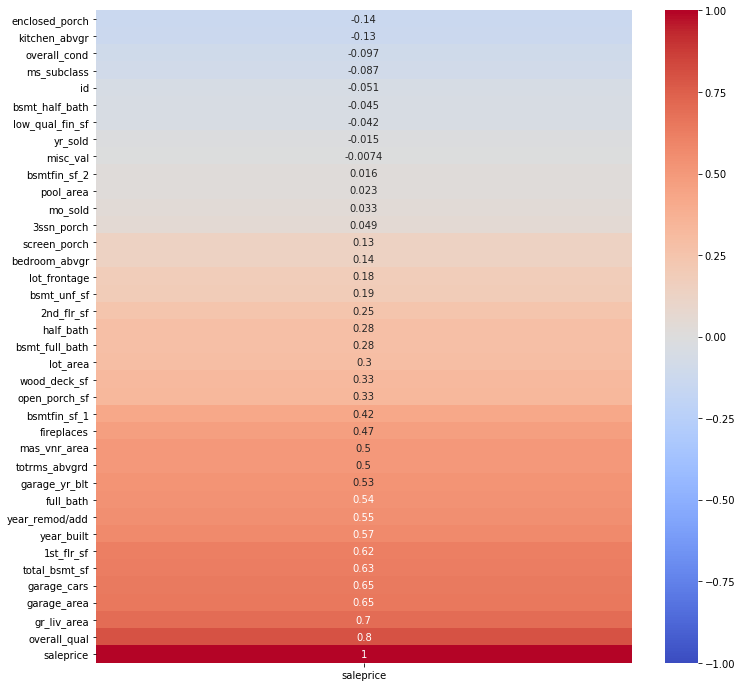

In [24]:
#Finding the correlations
corr = train_data.corr()[['saleprice']].sort_values('saleprice')
corr
plt.figure(figsize = (12, 12))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', vmin = -1, vmax = 1);

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


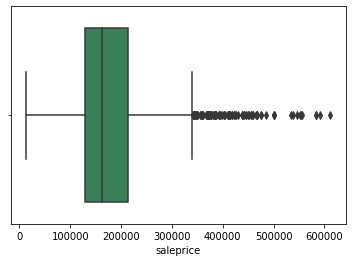

In [25]:
sns.boxplot(train_data.saleprice, color = 'seagreen');

Saleprice has a very large number of outliers. This could potentially cause my model to increase in prediction errors later, and I need to be mindful of that.

### Breakdown of Correlations with continuous (and some discrete) variables

I am breaking these down into multiple cells, due to the sheer volume of data columns.

<Figure size 1008x864 with 0 Axes>

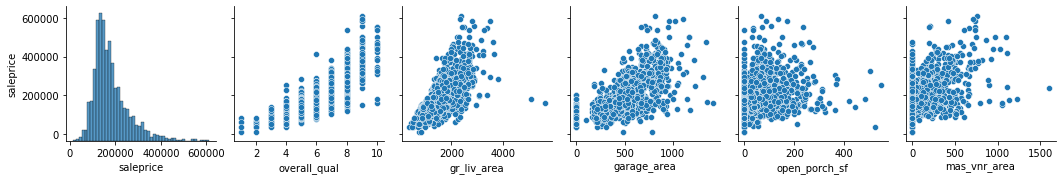

In [26]:
#Collection of correlations:
plt.figure(figsize = (14, 12))
sns.pairplot(train_data, y_vars = ['saleprice'], x_vars = ['saleprice','overall_qual', 'gr_liv_area', 
                            'garage_area','open_porch_sf','mas_vnr_area']);



<Figure size 1008x864 with 0 Axes>

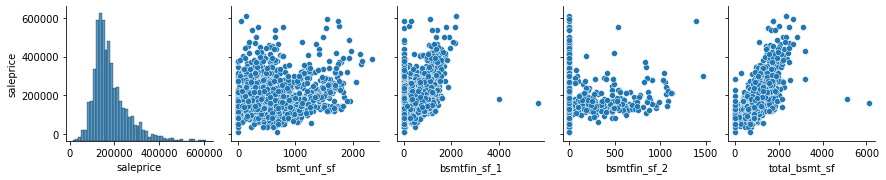

In [27]:
plt.figure(figsize = (14, 12))
sns.pairplot(train_data, y_vars = ['saleprice'], x_vars = ['saleprice','bsmt_unf_sf','bsmtfin_sf_1',
            'bsmtfin_sf_2','total_bsmt_sf']);
#include square of bsmtfin_sf_1 and total_bsmt_sf

<Figure size 1008x864 with 0 Axes>

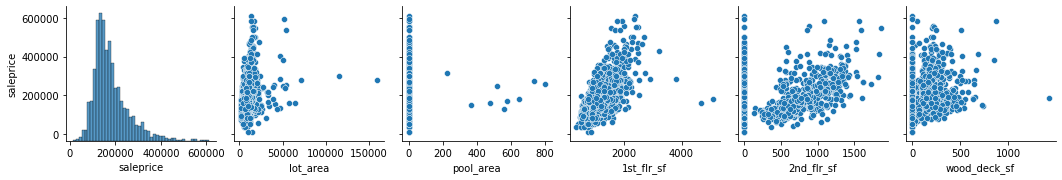

In [28]:
plt.figure(figsize = (14, 12))
sns.pairplot(train_data, y_vars = ['saleprice'], x_vars = ['saleprice','lot_area','pool_area',
                                                           '1st_flr_sf', '2nd_flr_sf','wood_deck_sf']);

#include square of 1st_flr_sf

**Distribution of the data**

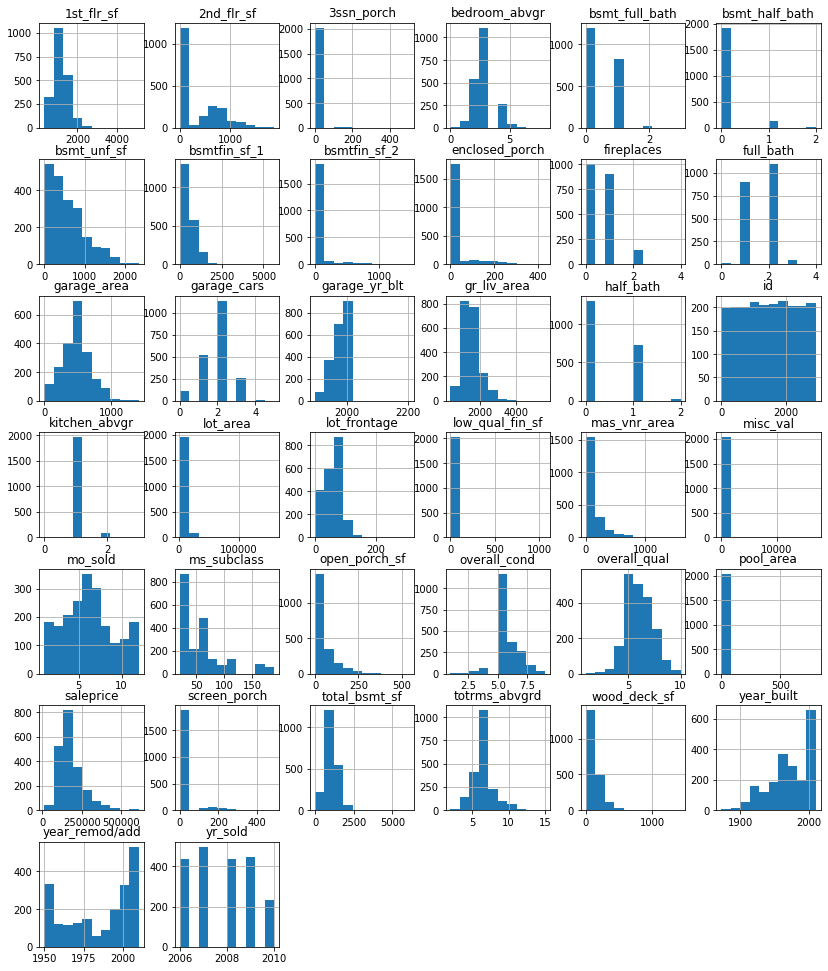

In [29]:
train_data.hist(figsize = (14,17));
#consider np.log() of: 1st_fl_sf, bsmt_unf_sf, bsmtfin_sf_1, garage_area, gr_liv_area to help reduce consistent
#under guessing by the model.

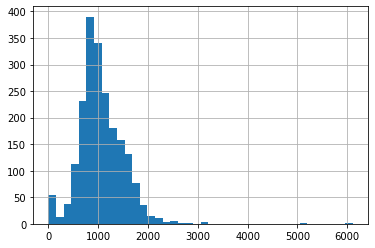

In [30]:
train_data.total_bsmt_sf.hist(bins = 40); #Didn't show up in my main hist.

Some preliminary findings: 

- The distribution of saleprice is very right skewed, and has has a large number of positive outliers. It is likely if kept to scale that the model will consistently underpredict the higher end sales values. Therefore, it will be wise when building my predictive model to set my target as the the natural log of saleprice.

- ALL of the squarefoot and area features in this dataset also have a right skew in their distributions (those with 'sf' or 'area' in their column names). Consider when seeking methods of improving fit later on - if including these are features - interpreting them also as their log values (More on this in the predictive model section). 

- Three of the highest correlating variables - gr_liv_area (the above ground living area), total basement area, and 1st floor square footage - all appear to be exponentially related (their correlation to saleprice is curved). Consider squaring these variables to more closely match to the trend of the correlations.


## Analysis of more categorical variables
---

Many of these code cells are repetitive - multiple categorical variable are being arranged into tiers, grouped together and analyzed for correlation. *These are primarily for exploratory uses, so feel free to "skim" this section!*

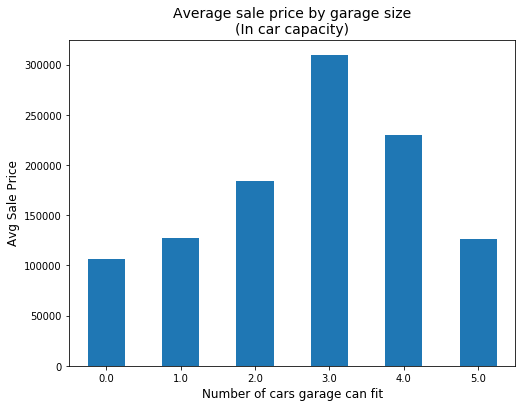

In [31]:
garage_car_price = train_data.groupby('garage_cars').saleprice.mean()
garage_car_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by garage size\n(In car capacity)', fontsize = 14)
plt.xlabel('Number of cars garage can fit', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);
#Very strong correlation with diminishing returns. This is garage area expressed as number of cars that fit.

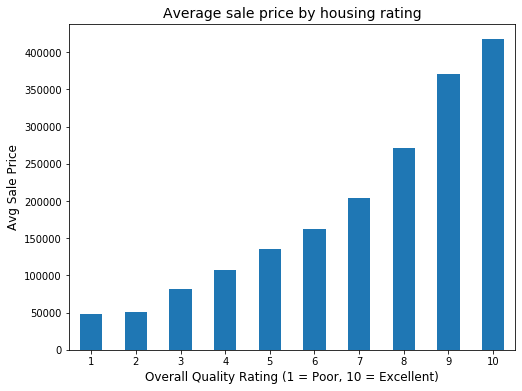

In [32]:
quality_price = train_data.groupby('overall_qual').saleprice.mean()
quality_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by housing rating', fontsize = 14)
plt.xlabel('Overall Quality Rating (1 = Poor, 10 = Excellent)', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);

#This is very likely to be the strongest predictor for me.
#plt.savefig('Images/Avg_price_by_rating.png')

In [33]:
#Grouping by years to see if various sets of decades have an impact on housing price

train_data['year_built_range'] = pd.cut(train_data.year_built,[0,1900,1940,1980,2000,
                                    train_data.year_built.max()],
                                    labels=['Before 1900','1900-1940','1940-1980','1980-2000','After 2000'])

#Repeat for test data
test_data['year_built_range'] = pd.cut(test_data.year_built,[0,1900,1940,1980,2000,
                                    test_data.year_built.max()],
                                    labels=['Before 1900','1900-1940','1940-1980','1980-2000','After 2000'])

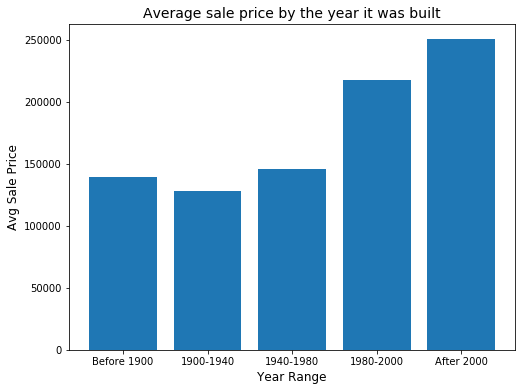

In [34]:
year_built_price = train_data.groupby('year_built_range').saleprice.mean().reset_index()

plt.figure(figsize = (8,6))

plt.bar(year_built_price.year_built_range, year_built_price.saleprice)

plt.title('Average sale price by the year it was built', fontsize = 14)
plt.xlabel('Year Range', fontsize = 12)

plt.ylabel('Avg Sale Price', fontsize = 12); 
#Another powerful predictor, though it moves at a bit of a curve

In [35]:
#Do this for test data as well
train_data['year_remod_range'] = pd.cut(train_data['year_remod/add'], [0, 1969, 1990, 2010],
                                       labels = ['Before 1970', '1970-1990', '1990 - 2010'])

test_data['year_remod_range'] = pd.cut(test_data['year_remod/add'], [0, 1969, 1990, 2010],
                                       labels = ['Before 1970', '1970-1990', '1990 - 2010'])

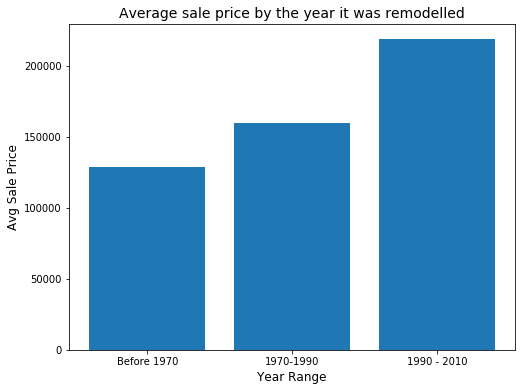

In [36]:
year_remod_price = train_data.groupby('year_remod_range').saleprice.mean().reset_index()

plt.figure(figsize = (8,6))

plt.bar(year_remod_price.year_remod_range, year_remod_price.saleprice)

plt.title('Average sale price by the year it was remodelled', fontsize = 14)
plt.xlabel('Year Range', fontsize = 12)

plt.ylabel('Avg Sale Price', fontsize = 12); 
#Another powerful predictor!
#plt.savefig('Images/P_Model_Features/Avg_price_remod.png')

In [37]:
train_data['garage_yr_blt_range'] = pd.cut(train_data['garage_yr_blt'], [0, 1969, 1990, 2010],
                                       labels = ['Before 1970', '1970-1990', '1990 - 2010'])

test_data['garage_yr_blt_range'] = pd.cut(test_data['garage_yr_blt'], [0, 1969, 1990, 2010],
                                       labels = ['Before 1970', '1970-1990', '1990 - 2010'])

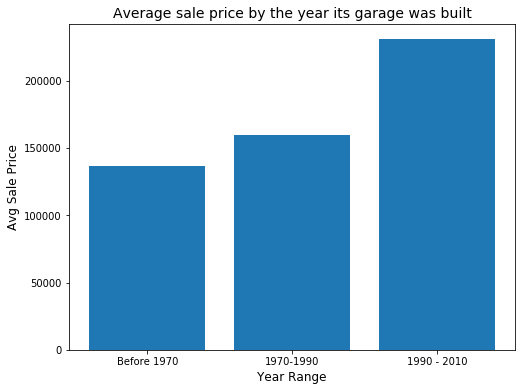

In [38]:
garage_built_price = train_data.groupby('garage_yr_blt_range').saleprice.mean().reset_index()

plt.figure(figsize = (8,6))

plt.bar(garage_built_price.garage_yr_blt_range, garage_built_price.saleprice)

plt.title('Average sale price by the year its garage was built', fontsize = 14)
plt.xlabel('Year Range', fontsize = 12)

plt.ylabel('Avg Sale Price', fontsize = 12); 
#Another powerful predictor!

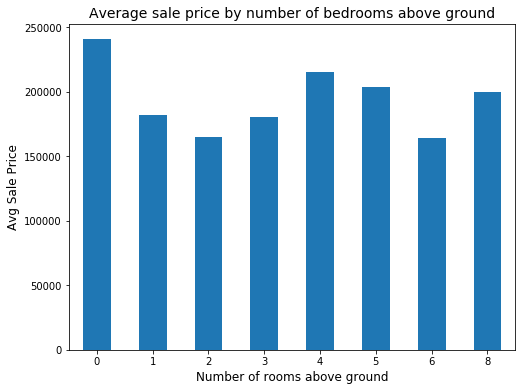

In [39]:
bedrooms_price = train_data.groupby('bedroom_abvgr').saleprice.mean()
bedrooms_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by number of bedrooms above ground', fontsize = 14)
plt.xlabel('Number of rooms above ground', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);
#Not actually a strong indicator. The trend is fairly noisy.

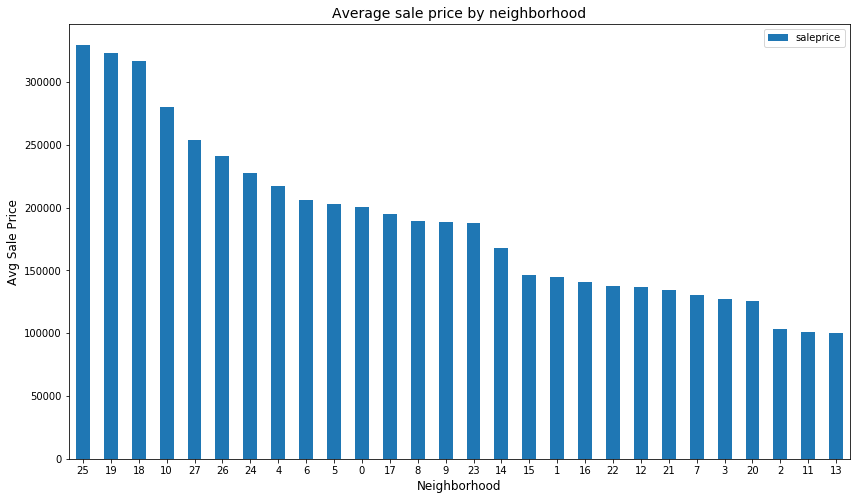

In [40]:
neighborhood_price = train_data.groupby('neighborhood').saleprice.mean().reset_index()
neighborhood_price.sort_values(by = 'saleprice',ascending = False, inplace = True)
neighborhood_price.plot.bar(figsize = (14,8), rot = 0);

plt.title('Average sale price by neighborhood', fontsize = 14)
plt.xlabel('Neighborhood', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);
#Much too noisy for use. Will likely overfit. Let's enhance this feature
#plt.savefig('Images/Avg_price_by_neighborhood.png')

These neighborhoods are very strongly matched to average saleprice. I will divide these into "tiers" that will ordinally rank them, for better predictive results on my linear model optimized for prediction.

In [41]:
#neighborhood tiers - dividing based on the trends in this bar chart, from tier 1 to tier 5
#I'm essentially teaching my model to know desirable neighborhoods - location, location, location!
tier1 = neighborhood_price[:3].neighborhood.values.tolist()
tier2 = neighborhood_price[3:6].neighborhood.values.tolist()
tier3 = neighborhood_price[6:15].neighborhood.values.tolist()
tier4 = neighborhood_price[15:25].neighborhood.values.tolist()
tier5 = neighborhood_price[25:].neighborhood.values.tolist()

In [42]:
#Attempting to help my model learn desirable locations
train_data['neighborhood_rank'] = train_data.neighborhood.apply(lambda x: 5 if x in tier1 else
                                        4 if x in tier2 else 3 if x in tier3 else 2 if
                                                        x in tier4 else 1)

#repeat for testing data
test_data['neighborhood_rank'] = test_data.neighborhood.apply(lambda x: 5 if x in tier1 else
                                        4 if x in tier2 else 3 if x in tier3 else 2 if
                                                        x in tier4 else 1)

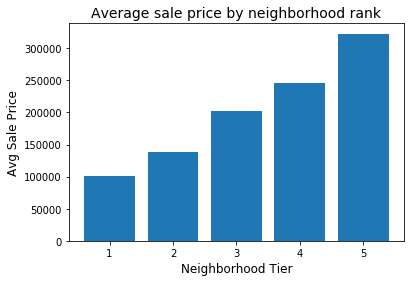

In [43]:
neighborhood_rank_price = train_data.groupby('neighborhood_rank').saleprice.mean().reset_index()
neighborhood_rank_price.sort_values(by = 'saleprice',ascending = False, inplace = True)
plt.bar(neighborhood_rank_price.neighborhood_rank, neighborhood_rank_price.saleprice)


plt.title('Average sale price by neighborhood rank', fontsize = 14)
plt.xlabel('Neighborhood Tier', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);
#plt.savefig('Images/Avg_price_by_neighborhood_rank.png')

This simpler representation, I feel, captures the positive trend of location in a way that can both improve predictive capability and make the resulting coefficients far easier to interpret in a meaningful way.

**Note on above - highest tier is a 5 (this is for multiplier effect).**

Finally, an extra predictive variable for being in the top tier neighborhoods can also be added.

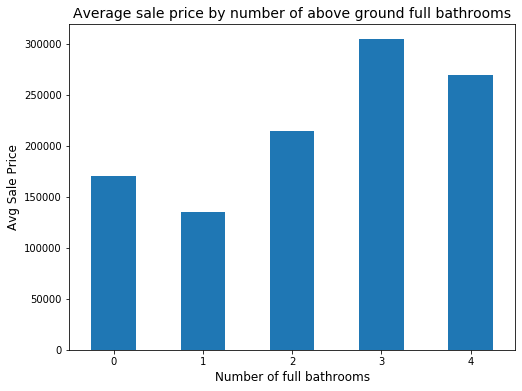

In [44]:
full_bath_price = train_data.groupby('full_bath').saleprice.mean()
full_bath_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by number of above ground full bathrooms', fontsize = 14)
plt.xlabel('Number of full bathrooms', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);
# Slightly strange how high priced the zero full baths category is-must have nice basement bathrooms!

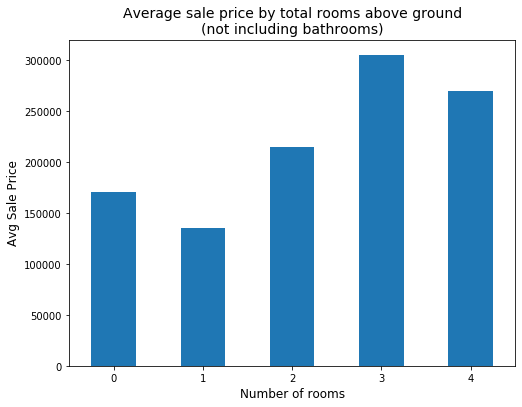

In [45]:
all_rooms_abvgrd_price = train_data.groupby('totrms_abvgrd').saleprice.mean()
full_bath_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by total rooms above ground\n(not including bathrooms)', fontsize = 14)
plt.xlabel('Number of rooms', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);
#Could be useful.. still a little noisy but a good trend. Maybe totrms_abvgrd * full_bath?

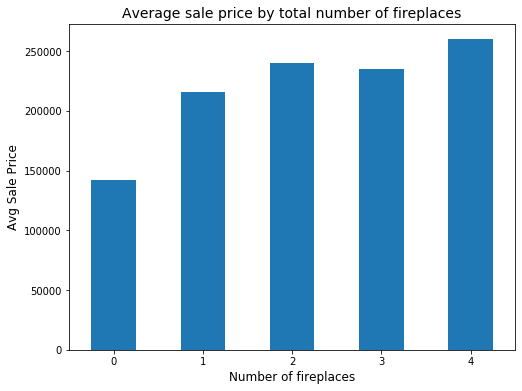

In [46]:
fireplace_price = train_data.groupby('fireplaces').saleprice.mean()
fireplace_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by total number of fireplaces', fontsize = 14)
plt.xlabel('Number of fireplaces', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);

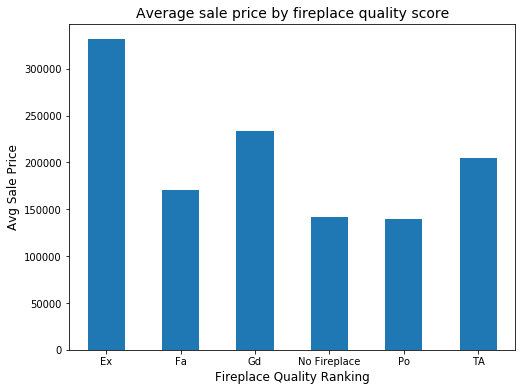

In [47]:
fireplace_quality_price = train_data.groupby('fireplace_qu').saleprice.mean()
fireplace_quality_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by fireplace quality score', fontsize = 14)
plt.xlabel('Fireplace Quality Ranking', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);
#Fireplaces is a good predictor as well - out of order in this chart

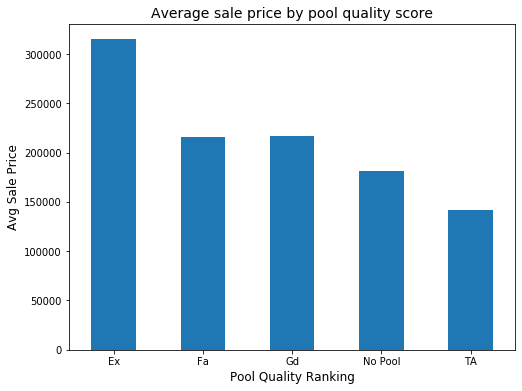

In [48]:
pool_quality_price = train_data.groupby('pool_qc').saleprice.mean()
pool_quality_price.plot.bar(figsize = (8,6), rot = 0);

plt.title('Average sale price by pool quality score', fontsize = 14)
plt.xlabel('Pool Quality Ranking', fontsize = 12)
plt.ylabel('Avg Sale Price', fontsize = 12);

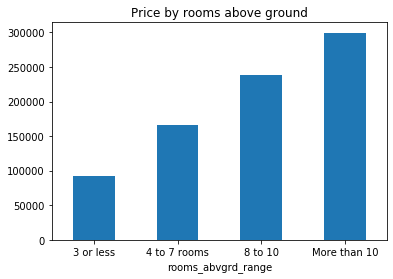

In [49]:
#train_data.totrms_abvgrd.unique()
train_data['rooms_abvgrd_range'] = train_data.totrms_abvgrd.apply(lambda x:
            '3 or less' if x <= 3 else '4 to 7 rooms' if 4 <= x <= 7 else '8 to 10' if 8 <= x <= 10 else
                                                                 'More than 10')
test_data['rooms_abvgrd_range'] = test_data.totrms_abvgrd.apply(lambda x:
            '3 or less' if x <= 3 else '4 to 7 rooms' if 4 <= x <= 7 else '8 to 10' if 8 <= x <= 10 else
                                                                 'More than 10')
rooms_above_ground = train_data.groupby('rooms_abvgrd_range').saleprice.mean()
rooms_above_ground.plot.bar(rot = 0)
plt.title('Price by rooms above ground');
#plt.savefig('Images/P_Model_Features/Price_rooms_abggrd.png')

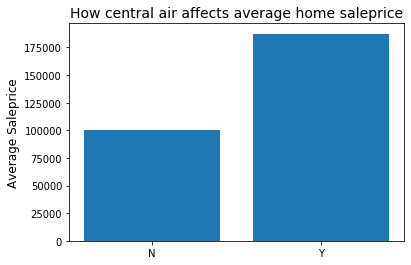

In [50]:
central_air_price = train_data.groupby('central_air').saleprice.mean().reset_index()
plt.bar(central_air_price.central_air, central_air_price.saleprice);
plt.title("How central air affects average home saleprice", fontsize = 14)
plt.ylabel('Average Saleprice', fontsize = 12);
#plt.savefig('Images/P_Model_Features/Central_air.png')

In [51]:
#Finally, age is an important factor!
train_data['age'] = train_data.year_built.apply(lambda x: 2020 - x)
test_data['age'] = test_data.year_built.apply(lambda x: 2020 - x)

In [52]:
train_data.year_remod_range.unique()

[1990 - 2010, Before 1970, 1970-1990]
Categories (3, object): [Before 1970 < 1970-1990 < 1990 - 2010]

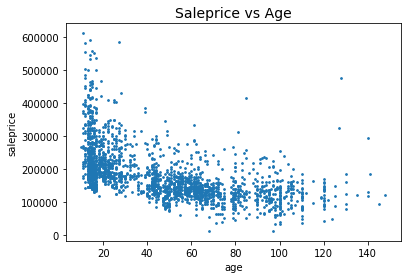

In [53]:
train_data.plot.scatter('age', 'saleprice', s = 3)
plt.title('Saleprice vs Age', fontsize = 14);
#plt.savefig('Images/saleprice_vs_age.png')

In [54]:
train_data.age.corr(train_data.saleprice) #Still a fairly strong correlation.

-0.5718488959135762

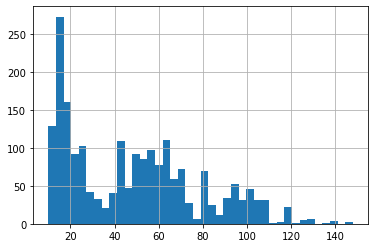

In [55]:
train_data.age.hist(bins = 40);

In order to interpret home square footage in a way that a realty company can easily work with, I will express home size as a total, taking the sum of all square footage values throughout the dataset.

In [56]:
#Creating a full property square footage:
train_data['total_property_sf'] = train_data.apply(lambda row: row['total_bsmt_sf'] + row['mas_vnr_area'] +
                                         row['1st_flr_sf'] + row['2nd_flr_sf'] + row['lot_area'] + 
                                        row['gr_liv_area'] + row['enclosed_porch'] +
                                        row['3ssn_porch'] + row['pool_area'] + row['screen_porch'] +
                                        row['garage_area'] + row['wood_deck_sf'] + row['open_porch_sf'],
                                                  axis = 1)

test_data['total_property_sf'] = test_data.apply(lambda row: row['total_bsmt_sf'] + row['mas_vnr_area'] +
                                         row['1st_flr_sf'] + row['2nd_flr_sf'] + row['lot_area'] + 
                                        row['gr_liv_area'] + row['enclosed_porch'] +
                                        row['3ssn_porch'] + row['pool_area'] + row['screen_porch'] +
                                        row['garage_area'] + row['wood_deck_sf'] + row['open_porch_sf'],
                                                  axis = 1)

## Problem Statement Questions
---

**1: Average Selling Price of Homes**

In [57]:
xbar, std, n = train_data.saleprice.mean(), train_data.saleprice.std(), len(train_data)

In [58]:
st.t_conf_intv(xbar, std, n)

(178037.5341217788, 184901.86909616366)

I can infer with 95% confidence from this data that the true average selling price of homes on the market is captured by the interval \\$178,000 - \$185,000.

However, this may be misleading, as the distribution of sales prices are very right skewed, so I will repeat this as well for the median.

In [59]:
med = train_data.saleprice.median()
st.t_conf_intv(med, std, n)

(159067.83251280757, 165932.16748719243)

I can infer with 95% confidence from this data that the true median selling price of homes on the market is captured by the interval \\$159,000 - \$166,000.

**2:Do newer houses (those less than 50 years old) sell significantly higher than the average sale price?**

- $H_{0}$: The difference between general saleprice and newer house saleprice means is 0 (they are they same).

- $H_{A}$: The difference between general saleprice and newer house saleprice means ≠ 0 (they are not the same).

In [60]:
newer_houses = train_data[train_data.age < 50].saleprice
tstat, pval = ttest_ind(train_data.saleprice, newer_houses)
pval

1.765347579299308e-37

With a pvalue of less than 0.05, I can reject the null hypothesis and state that this data is evidence that the mean saleprice of newer homes is not equal to the overall mean selling price.

**3:Do newer houses sell significanlty differently than the mean of older houses?**
- $H_{0}$: The difference between mean selling price of newer and older houses is 0 (they are they same).

- $H_{A}$: The difference between mean selling price of newer and older houses ≠ 0 (they are not the same).

In [61]:
older_houses = train_data[train_data.age >= 50].saleprice

tstat, pval = ttest_ind(newer_houses, older_houses)
pval

2.377085902834966e-147

I again can reject the null hypothesis, and state with 95% confidence that this data is evidence that the mean of newer and older houses is not the same.

**4:What is the true average selling price of newer houses?**

In [62]:
st.t_conf_intv(newer_houses.mean(), newer_houses.std(), len(newer_houses))

(215568.9567643538, 225342.8463350081)

I can infer with 95% confidence from this data that the true average selling price of newer homes on the market is captured by the interval \\$215500 - \$225000.

## Interpretable Linear Model
---

**Strongest features to include right away**
- Top: 'overall_qual', 'gr_liv_area', 'garage_area', 'year_remod_range', 'neighborhood_rank', 'total_bsmt_sf' and '1st_flr_sf'.

In [63]:
features = ['overall_qual', 'total_property_sf', 'age', 'neighborhood_rank']

X = train_data[features]
y = train_data.saleprice

In [64]:
X = pd.get_dummies(data = X, columns = ['overall_qual','neighborhood_rank'],
                  drop_first = True)

In [65]:
lm = LinearRegression()

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = (42))

In [67]:
lm.fit(X_train, y_train)

LinearRegression()

In [68]:
lm.score(X_train, y_train)

0.7986683999475332

In [69]:
lm.score(X_test, y_test)

0.7694256843673852

In [70]:
yhat = lm.predict(X_test)

In [71]:
np.sqrt(mean_squared_error(y_test, yhat))

37626.21426823021

This model has an acceptably low bias, and incredibly low variance. While I will add more features for the predictive model, this will suffice to help present an explanation of key coefficients in my deliverables.

In [72]:
pd.DataFrame(lm.coef_, index=X_train.columns, columns  = ['Coefficients'])

,Coefficients
total_property_sf,2.884990
age,-268.954295
overall_qual_2,37767.861873
overall_qual_3,46157.773879
overall_qual_4,71755.540006
overall_qual_5,87495.719851
overall_qual_6,105842.607441
overall_qual_7,129277.667432
overall_qual_8,167617.108724
overall_qual_9,242373.141904


In [73]:
X = sm.add_constant(X_test, prepend=True) #This is just for visual purposes
results = sm.OLS(y_test, X_test).fit()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [74]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                     143.0
Date:                Sat, 10 Oct 2020   Prob (F-statistic):          3.22e-164
Time:                        10:30:02   Log-Likelihood:                -6095.1
No. Observations:                 513   AIC:                         1.222e+04
Df Residuals:                     498   BIC:                         1.228e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
total_property_sf       1.7806      0.160     11.135      0.000       1.466       2.095
age                  -334.0329     76.683     -4.356      0.000    -484.694    -183.372
overall_qual_2       3.867e+04   1.86e+04      2.074      0.039    2033.986    7.53e+04
overall_qual_3       8.924e+04   1.83e+04      4.871      0.000    5.32e+04    1.25e+05
overall_qual_4       9.474e+04   1.02e+04      9.245      0.000    7.46e+04    1.15e+05
overall_qual_5        1.17e+05   9717.953     12.041      0.000    9.79e+04    1.36e+05
overall_qual_6       1.339e+05   9240.990     14.495      0.000    1.16e+05    1.52e+05
overall_qual_7        1.58e+05   9752.150     16.204      0.000    1.39e+05    1.77e+05
overall_qual_8        2.16e+05   1.05e+04     20.478      0.000    1.95e+05    2.37e+05
overall_qual_9       2.836e+05    1.3e+04     21.890      0.000    2.58e+05    3.09e+05
overall_qual_10      3.492e+05    1.9e+04     18.405      0.000    3.12e+05    3.86e+05
neighborhood_rank_2  1.638e+04   7677.770      2.133      0.033    1290.996    3.15e+04
neighborhood_rank_3  2.756e+04   8816.993      3.126      0.002    1.02e+04    4.49e+04
neighborhood_rank_4  2.761e+04   1.15e+04      2.411      0.016    5115.625    5.01e+04
neighborhood_rank_5  5.493e+04   1.07e+04      5.146      0.000     3.4e+04    7.59e+04
==============================================================================
Omnibus:                      162.147   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1120.518
Skew:                           1.194   Prob(JB):                    4.81e-244
Kurtosis:                       9.835   Cond. No.                     3.78e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.78e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Conditions for inference: LINE
---
**1: Linearity**

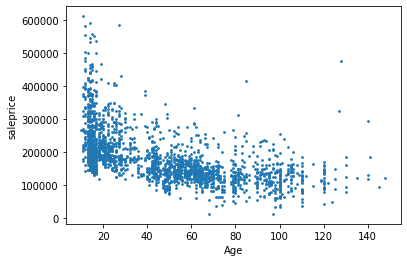

In [75]:
plt.scatter(train_data.age, train_data.saleprice, s = 3)
plt.xlabel('Age')
plt.ylabel('saleprice');
#Most other features have a linear relationship, but this feature has a curve toward the y axis. Still, the
#relationship is "close enough" to linear for me to feel confident in infering the coefficients at the range
#of 40-100 years of age.

**2: Independence is assumed in this model.**

**3: Normal Condtion:**

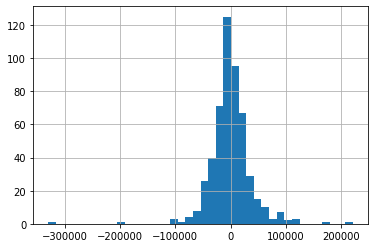

In [76]:
y_hat = lm.predict(X_test)
resids = y_test - y_hat
resids.hist(bins = 40); #There is a long left tail (indicating over predictions), but this distribution is
#approximately normal.

**4: Homoscedascticity**

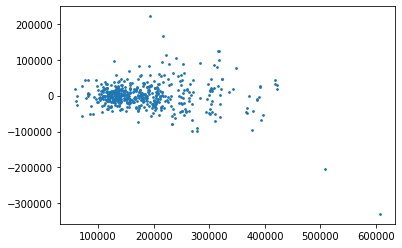

In [77]:
plt.scatter(y_hat, resids, s = 3); # A worrying downward trend on the higher values, howerver otherwise there
#Seems to be generally equal variance across most sale prices.

**Conclusion: I am satisfied that conditions are met to interpret these coefficients for my report.**

## Results : Interpretable Model
---
*Note that the "ranks" shown above increase in quality as the number increases.*

The probability f-statistic is extremely low, indicating a high probability that **at least one** coefficient is predicting our target of saleprice to some degree.

Further, each variable is likely to actually predict the true housing saleprice (each P|t| < 0.05, so we can reject the null hypothesis that the true coefficient is zero for each independent variable - meaning that they corrrelate to some value relatively close to our coefficient value..

- For every additional square foot of property, we can expect on average to see an increase in saleprice that is captured by the interval \\$1.47 - \$2.10 in sale price, holding all other factors constant (between a 1.5:1 and a 2:1 ratio).

- For every additional year of age for a home, we can expect on average to see a decrease in saleprice that is captured by the interval \\$183.37 - \$484.69 loss in selling price, holding all other factors constant.

- A home being at the top overall rank ("Very Excellent") predicts a home selling for an increase captured by the interval  \\$312,000 - \$386,000 more, relative to that same home being ranked in the lowest overall rank ("Very Poor")

- A home being in the top tier ranked neighborhoods (Stone Brook, Northridge Heights, and Northridge) is expected to sell for an increase in price captured by the interval \\$34,000 - \$76,000 higher value, relative to that same home being in the lowest tier ranked neighborhoods (Briardale, Iowa DOT and Railroad, and Meadow Village)

## Can we improve on this model?
---


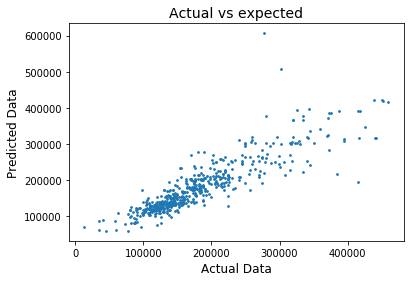

In [78]:

plt.scatter(y_test, y_hat, s = 3)
plt.title('Actual vs expected', fontsize = 14)
plt.xlabel('Actual Data', fontsize = 12)
plt.ylabel('Predicted Data', fontsize = 12); #This model is largely underpredicting higher home values.

## Further Engineering of features
---
The following are simple rendering of various other likely useful features from previous EDA in order to help "boost" the predictive model.

In [79]:
train_data.central_air = train_data.central_air.apply(lambda x: 1 if x == 'Y' else 0)
test_data.central_air = test_data.central_air.apply(lambda x: 1 if x == 'Y' else 0)

In [80]:
train_data.fireplace_qu = train_data.fireplace_qu.apply(lambda x: 0 if x == 'No Fireplace' else 1 if x == 'Po'
                                        else 2 if x == 'Fa' else 3 if x == 'TA' else 4 if x =='Gd' else 5)

test_data.fireplace_qu = test_data.fireplace_qu.apply(lambda x: 0 if x == 'No Fireplace' else 1 if x == 'Po'
                                        else 2 if x == 'Fa' else 3 if x == 'TA' else 4 if x =='Gd' else 5)

In [81]:
train_data.pool_qc = train_data.pool_qc.apply(lambda x: 0 if x == 'No Pool' else 1 if x == 'Fa'
                                        else 2 if x == 'TA' else 3 if x =='Gd' else 4)

test_data.pool_qc = test_data.pool_qc.apply(lambda x: 0 if x == 'No Pool' else 1 if x == 'Fa'
                                        else 2 if x == 'TA' else 3 if x =='Gd' else 4)

In [82]:
train_data.pool_qc.unique()

array([0, 1, 3, 4, 2])

In [83]:
train_data.ms_subclass =train_data.ms_subclass.apply(lambda x: str(x))
test_data.ms_subclass =test_data.ms_subclass.apply(lambda x: str(x))

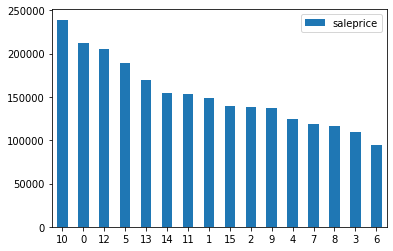

In [84]:
price_by_class = train_data.groupby('ms_subclass').saleprice.mean().reset_index()
price_by_class.sort_values(by = ['saleprice'], ascending = False, inplace = True)
price_by_class.plot.bar(rot = 0);
#Treat this not as numeric, but as separate classes, and it should match very well. Dummy it!

In [85]:
price_by_class.reset_index(inplace = True)

In [86]:
tier1 = price_by_class.ms_subclass.values.tolist()[0]
tier2 = price_by_class.ms_subclass.values.tolist()[1:4]
tier3 = price_by_class.ms_subclass.values.tolist()[4:11]
tier4 = price_by_class.ms_subclass.values.tolist()[11:]

In [87]:
train_data.ms_subclass = train_data.ms_subclass.apply(lambda x: 4 if x in tier1 else 3 if x in tier2 else 2
                                                     if x in tier3 else 1)

test_data.ms_subclass = test_data.ms_subclass.apply(lambda x: 4 if x in tier1 else 3 if x in tier2 else 2
                                                     if x in tier3 else 1)

In [88]:
train_data.heating_qc = train_data.heating_qc.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1)

test_data.heating_qc = test_data.heating_qc.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1)

In [89]:
train_data.garage_qual = train_data.garage_qual.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1 if
                                                     x == 'Po' else 0)

test_data.garage_qual = test_data.garage_qual.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1 if
                                                     x == 'Po' else 0)


In [90]:
train_data.kitchen_qual = train_data.kitchen_qual.apply(lambda x:4 if x == 'Ex' else 3 if x == 'Gd' else
                                            2 if x == 'TA' else 1)

test_data.kitchen_qual = test_data.kitchen_qual.apply(lambda x:4 if x == 'Ex' else 3 if x == 'Gd' else
                                            2 if x == 'TA' else 1)

In [91]:
train_data.exter_qual = train_data.exter_qual.apply(lambda x:4 if x == 'Ex' else 3 if x == 'Gd' else
                                            2 if x == 'TA' else 1)

test_data.exter_qual = test_data.exter_qual.apply(lambda x:4 if x == 'Ex' else 3 if x == 'Gd' else
                                            2 if x == 'TA' else 1)

In [92]:
train_data.exter_cond = train_data.exter_cond.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1)

test_data.exter_cond = test_data.exter_cond.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1)

In [93]:
train_data.bsmt_qual = train_data.bsmt_qual.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1 if
                                                     x == 'Po' else 0)

test_data.bsmt_qual = test_data.bsmt_qual.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1 if
                                                     x == 'Po' else 0)

In [94]:
train_data.bsmt_exposure = train_data.bsmt_exposure.apply(lambda x: 4 if x == 'Gd' else
                                            3 if x == 'Av' else 2 if x == 'Mn' else 1 if
                                                     x == 'No' else 0)

test_data.bsmt_exposure = test_data.bsmt_exposure.apply(lambda x: 4 if x == 'Gd' else
                                            3 if x == 'Av' else 2 if x == 'Mn' else 1 if
                                                     x == 'No' else 0)

In [95]:
train_data.garage_cond = train_data.garage_cond.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1 if
                                                     x == 'Po' else 0)

test_data.garage_cond = test_data.garage_cond.apply(lambda x:5 if x == 'Ex' else 4 if x == 'Gd' else
                                            3 if x == 'TA' else 2 if x == 'Fa' else 1 if
                                                     x == 'Po' else 0)

In [96]:
train_data.garage_finish = train_data.garage_finish.apply(lambda x:3 if x == 'Fin' else 2 if x == 'RFn' else 
                                                1 if x == 'Unf' else 0)

test_data.garage_finish = test_data.garage_finish.apply(lambda x:3 if x == 'Fin' else 2 if x == 'RFn' else 
                                                1 if x == 'Unf' else 0)

In [97]:
train_data['is_severe_slope'] = train_data.land_slope.apply(lambda x: 1 if x == 'Sev' else 0)
test_data['is_severe_slope'] = test_data.land_slope.apply(lambda x: 1 if x == 'Sev' else 0)


---


### Features to include next

It appears that correlation is difficult with so much data in place. In order to simplify, I will create new features that ask simple questions, such as:

- does the home have a fireplace?
- does it have a pool?
- does it have more than one story?
- does it have a basement?
- does it have more than one full bath?
- does it have a garage?
- does it have an open porch?
- does it have a wood deck?
- does it have a fence?

And similar yes/no answers, to capitalize on the correlation factors these features offer while reducing the inherent noise in the model. I will make a 2 sample t test of each yes/no mean, to determine the probability of any difference in mean saleprice being "real" to the population or a pheonomenon I can't discount as potentially random sampling noise. 

Finally, as the saleprice data is heavily right skewed, as well as many of the square footage columns, I will interpret log values of them to minimize consistent under predictions on higher values. I will also interpret several squared features, as many of theme correlate with saleprice with a positive correlation curve, which can be better captured with features that have been squared.

## Further Feature Engineering
---
In preparation for a more "powerful" predictive model, I will engineer and develop further features, which I will experiment with including and removing, testing for the highest possible score.

- Feel free to "scan" quickly over this section. It is primarily code to build out features, represent them numerically (so that I can use them as multipliers), squaring and logging features as well. These are all "doubled" in code, as they apply to both the training and testing data, so that I can predict the test data at the end as well.

In [98]:
#Yes/no question features
new_features = ['has_fireplace', 'has_pool', 'multi_floor', 'has_basement', 'multi_full_baths',
               'has_garage', 'has_open_porch', 'has_wood_deck', 'has_fence', 'has_misc', 'has_regular_lot',]

train_data['has_fireplace'] = train_data.fireplaces.apply(lambda x: 1 if x > 0 else 0)
train_data['has_pool'] = train_data.pool_area.apply(lambda x: 1 if x > 0 else 0)
train_data['multi_floor'] = train_data['2nd_flr_sf'].apply(lambda x: 1 if x > 0 else 0)
train_data['has_basement'] = train_data.total_bsmt_sf.apply(lambda x: 1 if x > 0 else 0)
train_data['multi_full_baths'] = train_data.full_bath.apply(lambda x: 1 if x > 0 else 0)
train_data['has_garage'] = train_data.garage_area.apply(lambda x: 1 if x > 0 else 0)
train_data['has_open_porch'] = train_data.open_porch_sf.apply(lambda x: 1 if x > 0 else 0)
train_data['has_wood_deck'] = train_data.wood_deck_sf.apply(lambda x: 1 if x > 0 else 0)
train_data['has_fence'] = train_data.fence.apply(lambda x: 0 if x == 'No Fence' else 1)
train_data['has_misc'] = train_data.misc_val.apply(lambda x: 1 if x > 0 else 0)
train_data['has_regular_lot'] = train_data.lot_shape.apply(lambda x: 1 if x == 'Reg' else 0)
#Next cell repeats for test data

In [99]:
test_data['has_fireplace'] = test_data.fireplaces.apply(lambda x: 1 if x > 0 else 0)
test_data['has_pool'] = test_data.pool_area.apply(lambda x: 1 if x > 0 else 0)
test_data['multi_floor'] = test_data['2nd_flr_sf'].apply(lambda x: 1 if x > 0 else 0)
test_data['has_basement'] = test_data.total_bsmt_sf.apply(lambda x: 1 if x > 0 else 0)
test_data['multi_full_baths'] = test_data.full_bath.apply(lambda x: 1 if x > 0 else 0)
test_data['has_garage'] = test_data.garage_area.apply(lambda x: 1 if x > 0 else 0)
test_data['has_open_porch'] = test_data.open_porch_sf.apply(lambda x: 1 if x > 0 else 0)
test_data['has_wood_deck'] = test_data.wood_deck_sf.apply(lambda x: 1 if x > 0 else 0)
test_data['has_fence'] = test_data.fence.apply(lambda x: 0 if x == 'No Fence' else 1)
test_data['has_misc'] = test_data.misc_val.apply(lambda x: 1 if x > 0 else 0)
test_data['has_regular_lot'] = test_data.lot_shape.apply(lambda x: 1 if x == 'Reg' else 0)

In [100]:
#For my own ability to evaluate significant differences in mean saleprice by the above features.

def two_samp_t_test_display(features):
    for item in features:
        t1 = train_data[train_data[item] == 0].saleprice
        t2 = train_data[train_data[item] != 0].saleprice
        t_score, pval = ttest_ind(t1, t2)
        print(f'Pval for null hypothesis that {item} does not affect mean saleprice: {pval}')
        

In [101]:
two_samp_t_test_display(new_features)

Pval for null hypothesis that has_fireplace does not affect mean saleprice: 5.677886630434671e-122
Pval for null hypothesis that has_pool does not affect mean saleprice: 0.27003646808189147
Pval for null hypothesis that multi_floor does not affect mean saleprice: 0.0003752660653686038
Pval for null hypothesis that has_basement does not affect mean saleprice: 7.608475531018574e-13
Pval for null hypothesis that multi_full_baths does not affect mean saleprice: 0.6877659014673143
Pval for null hypothesis that has_garage does not affect mean saleprice: 3.246781125050097e-26
Pval for null hypothesis that has_open_porch does not affect mean saleprice: 3.0411884860666238e-99
Pval for null hypothesis that has_wood_deck does not affect mean saleprice: 2.617492461914578e-47
Pval for null hypothesis that has_fence does not affect mean saleprice: 1.0803660454478544e-16
Pval for null hypothesis that has_misc does not affect mean saleprice: 0.028176701385576052
Pval for null hypothesis that has_regul

According to this data, the difference of mean saleprice value in both groups having a feature vs not having a feature shows evidence of statistical significance for every feature tested except for full_baths and a pool. I will start with those more powerful predictors in my model.

In [102]:

train_data['total_bathrooms'] = train_data.full_bath + train_data.half_bath + train_data.bsmt_full_bath +\
                            train_data.bsmt_half_bath

test_data['total_bathrooms'] = test_data.full_bath + test_data.half_bath + test_data.bsmt_full_bath +\
                            test_data.bsmt_half_bath

train_data['above_and_below'] = train_data['gr_liv_area'] * train_data['total_bsmt_sf']
test_data['above_and_below'] = test_data['gr_liv_area'] * test_data['total_bsmt_sf']

train_data['rooms_and_baths'] = train_data['totrms_abvgrd'] * train_data['full_bath']
test_data['rooms_and_baths'] = test_data['totrms_abvgrd'] * test_data['full_bath']

## Interpreted features
---
The following are just squaring and taking log of multiple features to experiment with. This is due to their trends in the scatter plot of saleprice, or their distribution, respectively.

In [103]:
#Interpreted features - squared
train_data['gr_liv_area^2'] = train_data['gr_liv_area'] ** 2
train_data['total_bsmt_sf^2'] = train_data['total_bsmt_sf'] **2
train_data['1st_flr_sf^2'] = train_data['1st_flr_sf'] **2
train_data['2nd_flr_sf^2'] = train_data['2nd_flr_sf'] **2
train_data['bsmtfin_sf_1^2'] = train_data['bsmtfin_sf_1'] **2
train_data['bsmtfin_sf_1^2'] = train_data['bsmtfin_sf_1'] **2
train_data['bsmt_unf_sf^2'] = train_data['bsmt_unf_sf'] **2
train_data['total_property_sf^2'] = train_data['total_property_sf'] **2
train_data['lot_area^2'] = train_data['lot_area'] ** 2
train_data['garage_area^2'] = train_data['garage_area'] ** 2
train_data['wood_deck_sf^2'] = train_data['wood_deck_sf'] ** 2
train_data['lot_area^2'] = train_data['lot_area'] ** 2


#Interpreted features - log (have to set to zero for when x = 0 or you'll get an error)
train_data['log_gr_live_area'] = train_data['gr_liv_area'].map(np.log)
train_data['log_total_bsmt_sf'] = train_data['total_bsmt_sf'].apply(lambda x: 0 if x == 0 else np.log(x))
train_data['log_garage_area'] = train_data['garage_area'].map(lambda x: 0 if x == 0 else np.log(x))
train_data['log_bsmt_unf_sf'] = train_data['bsmt_unf_sf'].map(lambda x: 0 if x == 0 else np.log(x))
train_data['log_1st_flr_sf'] = train_data['1st_flr_sf'].map(np.log)
train_data['log_bsmtfin_sf_1'] = train_data['bsmtfin_sf_1'].map(lambda x: 0 if x == 0 else np.log(x))
train_data['log_lot_area'] = train_data['lot_area'].map(np.log)
train_data['log_total_property_sf'] = train_data['total_property_sf'].map(np.log)

#Gotta do it again for test data!
test_data['gr_liv_area^2'] = test_data['gr_liv_area'] ** 2
test_data['total_bsmt_sf^2'] = test_data['total_bsmt_sf'] **2
test_data['1st_flr_sf^2'] = test_data['1st_flr_sf'] **2
test_data['2nd_flr_sf^2'] = test_data['2nd_flr_sf'] **2
test_data['bsmtfin_sf_1^2'] = test_data['bsmtfin_sf_1'] **2
test_data['bsmt_unf_sf^2'] = test_data['bsmt_unf_sf'] **2
test_data['lot_area^2'] = test_data['lot_area'] ** 2
test_data['garage_area^2'] = test_data['garage_area'] ** 2
test_data['wood_deck_sf^2'] = test_data['wood_deck_sf'] ** 2
test_data['lot_area^2'] = test_data['lot_area'] ** 2
test_data['total_property_sf^2'] = test_data['total_property_sf'] **2


test_data['log_gr_live_area'] = test_data['gr_liv_area'].map(np.log)
test_data['log_total_bsmt_sf'] = test_data['total_bsmt_sf'].apply(lambda x: 0 if x == 0 else np.log(x))
test_data['log_garage_area'] = test_data['garage_area'].map(lambda x: 0 if x == 0 else np.log(x))
test_data['log_bsmt_unf_sf'] = test_data['bsmt_unf_sf'].map(lambda x: 0 if x == 0 else np.log(x))
test_data['log_1st_flr_sf'] = test_data['1st_flr_sf'].map(np.log)
test_data['log_lot_area'] = test_data['lot_area'].map(np.log)
test_data['log_bsmtfin_sf_1'] = test_data['bsmtfin_sf_1'].map(lambda x: 0 if x == 0 else np.log(x))
test_data['log_total_property_sf'] = test_data['total_property_sf'].map(np.log)


**A note on above: not every column above will be included in the final model. Experimentation will be done to find which features are an optimal combination for my predictive model.

## Linear Model for optimal predictive power
---

Having analyzed the coefficients of the previous model to express how these important features impact housing price, this new model is designed to maximize predictive capability, at the cost of interpretability. 

In [104]:
#Below are two functions I use to quickly view metrics.
def r2_adj(X, y, yhat):
    '''
    Input target and predicted values to calculate adj r2 of the model's predictions.
    (1 - R2)(N-1) / N - p - 1, where N is sample size and p is number of predictors.
    '''
    N = y.shape[0]
    p = X.shape[1]
    
    r2 = r2_score(y, yhat)
    
    return 1 - ((1 - r2)*(N - 1) / (N - p - 1))

In [105]:
def various_metrics(X, y, yhat):
    #Make metrics, and return a df series of metrics and index as name of the metric calculated
    #Using metrics because I won't be able to know the name of the instance of fit
    indices = ['SSE', 'Mean Abs Error', 'MSE', 'RMSE', 'R2', 'R2 Adj']
    
    sse = ((y - yhat)**2).sum()
    
    mean_abs_err = mean_absolute_error(y, yhat)
    
    mse_score = mean_squared_error(y, yhat)
    
    rmse = np.sqrt(mse_score)
    
    r2 = r2_score(y, yhat)
    
    r2adjust = r2_adj(X, y, yhat)
    
    vals = [sse, mean_abs_err, mse_score, rmse, r2, r2adjust]
    return pd.Series(vals, index = indices)

In [106]:
#This is all values to get X started and do train_test_split

features = ['overall_qual','age','neighborhood_rank','pool_qc','neighborhood',
            'gr_liv_area','gr_liv_area^2','rooms_abvgrd_range','above_and_below',
            'total_bathrooms', 'full_bath','bldg_type','condition_1','condition_2',
            'exter_qual','exter_cond',
            'alley','central_air', 'heating', 'electrical',
            'kitchen_qual','bsmt_qual','bsmt_exposure', 'garage_cond','garage_finish',
            'overall_cond','log_lot_area','garage_qual','is_severe_slope',
          'garage_area','garage_area^2','year_remod_range', 'garage_yr_blt_range',
          'fireplaces', 'fireplace_qu','has_fireplace', 'has_open_porch',
          'total_bsmt_sf','total_bsmt_sf^2','bsmtfin_sf_1', 'bsmtfin_sf_1^2','bsmt_unf_sf',
          '1st_flr_sf','1st_flr_sf^2', '2nd_flr_sf','low_qual_fin_sf','sale_type',
            'total_property_sf'] 

#This is for my scale model. I will separate out these for scaling...
num_features = ['age','gr_liv_area','gr_liv_area^2','log_lot_area',
                'garage_area','garage_area^2',
                'total_bsmt_sf','total_bsmt_sf^2','bsmtfin_sf_1',
                'bsmtfin_sf_1^2', 'bsmt_unf_sf','1st_flr_sf',
                '1st_flr_sf^2', '2nd_flr_sf','low_qual_fin_sf','total_property_sf'] 

#These are the features I want to make dummies of
dummy_features = ['neighborhood','rooms_abvgrd_range','bldg_type','condition_1',
                  'condition_2', 'alley', 'heating','electrical', 'garage_cond','garage_finish',
                  'year_remod_range', 'garage_yr_blt_range',
                          'fireplaces','sale_type']


X = train_data[features]
y = train_data.saleprice

In [107]:
X = pd.get_dummies(data = X, columns = dummy_features, drop_first = True)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = (42), test_size = 0.2,
                                                   train_size = 0.8)

Scaling of numerical features, in order to utilize Lasso and Ridge if necessary

In [109]:
sc = StandardScaler()

In [110]:
ct = ColumnTransformer([('scale_few', StandardScaler(), num_features)], remainder='passthrough')

In [111]:
Z_train = ct.fit_transform(X_train)
Z_test = ct.transform(X_test)

y_train_log = y_train.map(np.log)
y_test_log = y_test.map(np.log)

In [112]:
lr = LinearRegression()

In [115]:
#Preliminary test of linear modelling fit
cross_val_score(lr, Z_train, y_train_log).mean() #.8836 currently!

0.9072344469787437

In [118]:
lr.fit(Z_train, y_train_log)

LinearRegression()

In [119]:
y_test_log = y_test.map(np.log)

In [120]:
lr.score(Z_train, y_train_log) #.928

0.9309738477714569

In [121]:
lr.score(Z_test, y_test_log) #.8709
#The unscaled model performs well. Let's see if I can boost this a little more

0.8687649761335805

In [122]:
yhat_log_lr = lr.predict(Z_test)
np.sqrt(mean_squared_error(y_test, yhat_log_lr))

196237.10880028762

## Error minimization attempts
---
Bias in this model has been minimized, given the very high R2 score on my training data. The variance in this model is growing with each feature but is still not overly high. Even still, let's check to be sure that the scaled model fit to Lasso or Ridge will not be an improvement!

In [123]:
l_alphas = np.logspace(-6, 1, 130)

lasso_cv = LassoCV(alphas = l_alphas, cv = 5, max_iter = 50_000)

lasso_cv.fit(Z_train, y_train_log)

print(lasso_cv.score(Z_train, y_train_log))

print(lasso_cv.score(Z_test, y_test_log))
#Not as efective. We do not want to drop coefficients with Lasso then! Now try ridge
#.911 and .889
yhat_log_lasso = lasso_cv.predict(Z_test)

np.sqrt(mean_squared_error(y_test, yhat_log_lasso)) #Ok...

0.9278867005673419
0.8831360026657925


196237.1082150386

In [124]:
r_alphas = np.logspace(1,7,140)
ridge_cv =  RidgeCV(alphas = r_alphas, scoring = 'r2', cv = 5)

ridge_cv.fit(Z_train, y_train_log)

RidgeCV(alphas=array([1.00000000e+01, 1.10449936e+01, 1.21991883e+01, 1.34739957e+01,
       1.48820195e+01, 1.64371810e+01, 1.81548559e+01, 2.00520267e+01,
       2.21474506e+01, 2.44618449e+01, 2.70180920e+01, 2.98414653e+01,
       3.29598792e+01, 3.64041654e+01, 4.02083773e+01, 4.44101269e+01,
       4.90509567e+01, 5.41767501e+01, 5.98381857e+01, 6.60912377e+01,
       7.29977296e+01, 8.06259454e+0...
       1.01670333e+06, 1.12294817e+06, 1.24029553e+06, 1.36990562e+06,
       1.51305988e+06, 1.67117366e+06, 1.84581024e+06, 2.03869622e+06,
       2.25173867e+06, 2.48704391e+06, 2.74693840e+06, 3.03399170e+06,
       3.35104188e+06, 3.70122361e+06, 4.08799910e+06, 4.51519238e+06,
       4.98702708e+06, 5.50816821e+06, 6.08376825e+06, 6.71951812e+06,
       7.42170345e+06, 8.19726669e+06, 9.05387580e+06, 1.00000000e+07]),
        cv=5, scoring='r2')

In [125]:
ridge_cv.score(Z_train, y_train_log) #.92775

0.9249183990586095

In [126]:
ridge_cv.score(Z_test, y_test_log)

0.8963248802895672

In [127]:
yhat_log_ridge = ridge_cv.predict(Z_test)

np.sqrt(mean_squared_error(y_test, yhat_log_ridge))

196237.10760203304

In [129]:
l_alphas = np.logspace(-4, 7, 120)
ratios = [0.1, 0.3, 0.5, 0.7, 0.9]
en_cv = ElasticNetCV(l1_ratio = ratios, alphas = l_alphas, cv = 5)

In [143]:
en_cv.fit(Z_train, y_train_log)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.317522796897217, tolerance: 0.021889803694889902
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.309519207680051, tolerance: 0.021889803694889902
  tol, rng, random, positive)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:527: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6.247423470250267, tolerance: 0.021889803694889902
  tol, rng, random, positive)
/Library/Frameworks/Python.framewo

ElasticNetCV(alphas=array([1.00000000e-04, 1.23719163e-04, 1.53064314e-04, 1.89369889e-04,
       2.34286842e-04, 2.89857721e-04, 3.58609548e-04, 4.43668733e-04,
       5.48903245e-04, 6.79098503e-04, 8.40174987e-04, 1.03945747e-03,
       1.28600808e-03, 1.59103844e-03, 1.96841945e-03, 2.43531207e-03,
       3.01294772e-03, 3.72759372e-03, 4.61174777e-03, 5.70561576e-03,
       7.05894009e-03, 8.733261...
       7.48082646e+04, 9.25521591e+04, 1.14504757e+05, 1.41664327e+05,
       1.75265921e+05, 2.16837531e+05, 2.68269580e+05, 3.31900880e+05,
       4.10624992e+05, 5.08021805e+05, 6.28520327e+05, 7.77600091e+05,
       9.62040327e+05, 1.19022824e+06, 1.47254043e+06, 1.82181470e+06,
       2.25393390e+06, 2.78854817e+06, 3.44996847e+06, 4.26827213e+06,
       5.28067057e+06, 6.53320146e+06, 8.08282219e+06, 1.00000000e+07]),
             cv=5, l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9])

In [144]:
en_cv.score(Z_train, y_train_log)

0.9279088809095614

In [145]:
en_cv.score(Z_test, y_test_log)

0.8833782852528252

In [147]:
yhat_lr = np.exp(yhat_log_lr)
yhat_ridge = np.exp(yhat_log_ridge)
yhat_lasso = np.exp(yhat_log_lasso)
preds_en = en_cv.predict(Z_test)
yhat_en = np.exp(preds_en)

resids_lr = y_test - yhat_lr
resids_ridge = y_test - yhat_ridge
resids_lasso = y_test - yhat_lasso
resids_elastic = y_test - yhat_en

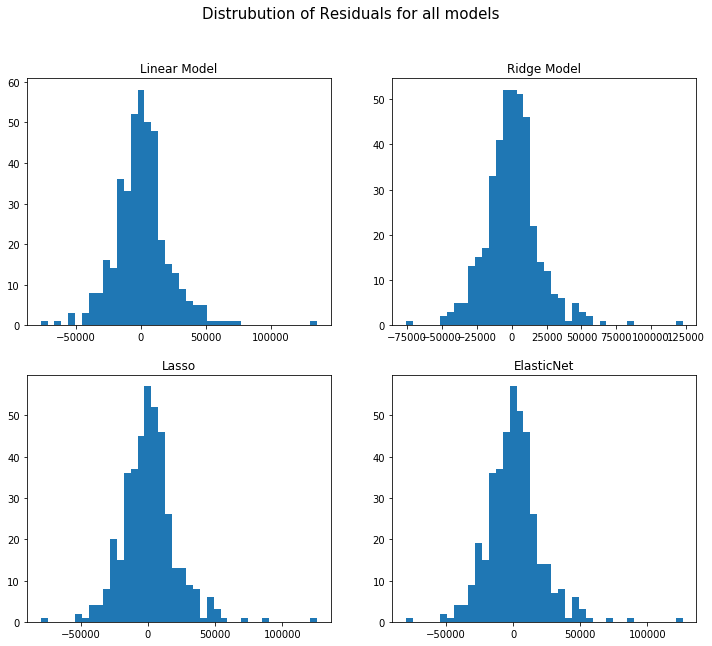

In [148]:
plt.figure(figsize = (12,10))
plt.suptitle('Distrubution of Residuals for all models', fontsize = 15)
ax1 = plt.subplot(2, 2, 1)
plt.hist(resids_lr, bins = 40)
plt.title('Linear Model')

ax2 = plt.subplot(2, 2, 2)
plt.hist(resids_ridge, bins = 40)
plt.title('Ridge Model')

ax3 = plt.subplot(2, 2, 3)
plt.hist(resids_lasso, bins = 40)
plt.title('Lasso')

ax4 = plt.subplot(2, 2, 4)
plt.hist(resids_elastic, bins = 40)
plt.title('ElasticNet');
#plt.savefig('Images/P_Model_Features/Dist_resids_models.png')

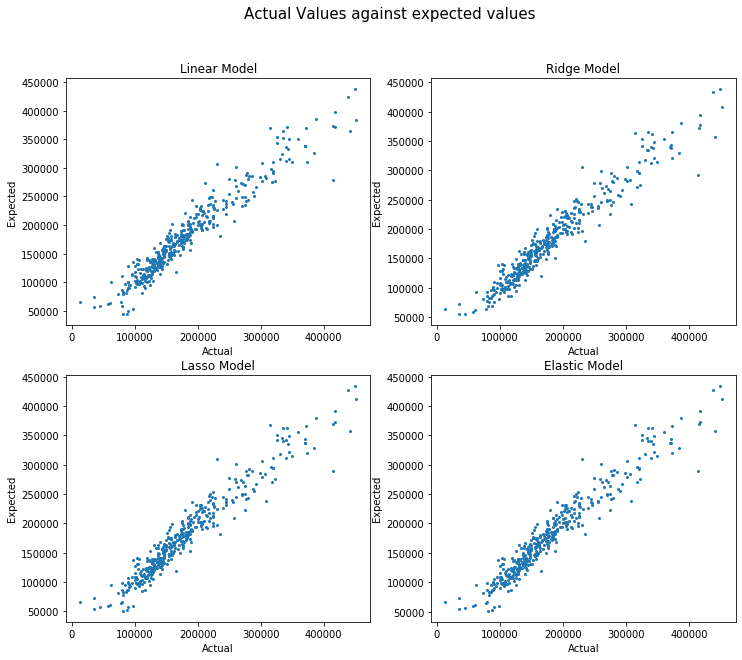

In [150]:
plt.figure(figsize = (12, 10))
plt.suptitle('Actual Values against expected values', fontsize = 15)

ax1 = plt.subplot(2, 2, 1)
plt.scatter(y_test, yhat_lr, s = 4)
plt.title('Linear Model', fontsize = 12)
plt.xlabel('Actual')
plt.ylabel('Expected')

ax1 = plt.subplot(2, 2, 2)
plt.scatter(y_test, yhat_ridge, s = 4)
plt.title('Ridge Model', fontsize = 12)
plt.xlabel('Actual')
plt.ylabel('Expected')

ax1 = plt.subplot(2, 2, 3)
plt.scatter(y_test, yhat_lasso, s = 4)
plt.title('Lasso Model', fontsize = 12)
plt.xlabel('Actual')
plt.ylabel('Expected')

ax1 = plt.subplot(2, 2, 4)
plt.scatter(y_test, yhat_en, s = 4)
plt.title('Elastic Model', fontsize = 12)
plt.xlabel('Actual')
plt.ylabel('Expected');
#plt.savefig('Images/P_Model_Features/Act_vs_exp_all_models.png')

So far, it appears that all three models have very high R^2 scores, are normally distributed residuals - from the scatterplot as well, all 3 models are prone to under predicting the higher values, though interestingly the ridge regularization method appears to minimize overpreditions on the lower saleprice end. It is likely that this will be the best model to deliver.

In [125]:
#Original Model
various_metrics(X_test, y_test, yhat_lr)

SSE               1.779803e+11
Mean Abs Error    1.489742e+04
MSE               4.330420e+08
RMSE              2.080966e+04
R2                9.271159e-01
R2 Adj            8.980120e-01
dtype: float64

In [126]:
print('Metrics of Ridge Model')
various_metrics(Z_test, y_test, yhat_ridge)

Metrics of Ridge Model


SSE               1.570921e+11
Mean Abs Error    1.401784e+04
MSE               3.822192e+08
RMSE              1.955043e+04
R2                9.356697e-01
R2 Adj            9.099816e-01
dtype: float64

In [127]:
various_metrics(Z_test, y_test, yhat_lasso)

SSE               1.658303e+11
Mean Abs Error    1.442883e+04
MSE               4.034801e+08
RMSE              2.008681e+04
R2                9.320914e-01
R2 Adj            9.049743e-01
dtype: float64

In [152]:
various_metrics(Z_test, y_test, yhat_en)

SSE               1.657955e+11
Mean Abs Error    1.442803e+04
MSE               4.033954e+08
RMSE              2.008471e+04
R2                9.321056e-01
R2 Adj            9.049942e-01
dtype: float64

In fact, Ridge performs best on the RMSE metric as well. I will now prepare the testing data for use in the ridge regularization model, so that our client can utilize it for any new homes they wish to predict.

*Side note: this is my kaggle subission method, too.*

In [153]:
# #Prepping for submission - test data receives all of the same treatment for features, so the model can interpret
#the data and predict results.
X_submit = test_data[features]

X_submit = pd.get_dummies(data = X_submit, columns = dummy_features, drop_first = True)

In [154]:
#Because some dummy variables are not equally created, a set here is made to match all columns in both
#Testing and submitting data
set1 = set(X_submit.columns)
set2 = set(X_train.columns)
adds = set2.difference(set1)
set2.difference(set1)

{'condition_2_Feedr',
 'condition_2_PosN',
 'condition_2_RRAe',
 'condition_2_RRAn',
 'condition_2_RRNn',
 'electrical_Mix',
 'fireplaces_4',
 'heating_OthW',
 'heating_Wall',
 'neighborhood_GrnHill',
 'neighborhood_Landmrk'}

In [155]:
for cols in adds:
    X_submit[cols] = 0

In [156]:
cols = X_train.columns

In [157]:
X_submit = X_submit[cols]

In [158]:
Z_submit = ct.transform(X_submit)

In [159]:
print(Z_train.shape)
Z_submit.shape #Good to go

(1640, 117)


(878, 117)

Final notes here: Ridge Appears to have been the highest performing model, so that is what I will predict with.

In [160]:
yhat_submit = en_cv.predict(Z_submit)

In [161]:
#Predictions are log values, so they must be converted prior to submission for a sensible read of saleprice.
yhat_final = np.exp(yhat_submit)
yhat_final[:10]

array([121918.30072874, 155307.80788834, 223425.09115702, 107129.65336041,
       169065.42961281,  93692.78427797, 109685.5947477 , 157971.67510702,
       183605.45580213, 169658.1931228 ])

In [162]:
submission = pd.DataFrame({'ID': test_data.id, 'SalePrice':yhat_final})

In [138]:
submission.head()
#submission.to_csv('datasets/new_submission.csv', index = False)

,ID,SalePrice
0,2658,120809.520442
1,2718,155633.765321
2,2414,221562.820684
3,1989,106063.447811
4,625,169250.226914


In [139]:
#Making sure that the layout is appropriate to desired specs.
check = pd.read_csv('datasets/new_submission.csv')
check.head()

,ID,SalePrice
0,2658,120809.520442
1,2718,155633.765321
2,2414,221562.820684
3,1989,106063.447811
4,625,169250.226914


## Conclusions:
---
- I can infer with 95% confidence from this data that the true average selling price of homes on the market is captured by the interval \\$178000 - \$185000.

*However, this may be misleading, as the distribution of sales prices are very right skewed, so I am also including here the median sale price.*

- I can infer with 95% confidence from this data that the true median selling price of homes on the market is captured by the interval \\$159,000 - \$166,000.

- I can state that this data is evidence that the mean saleprice of newer homes is not equal to the overall mean selling price.

- I again can state with 95% confidence that this data is evidence that the mean of newer and older houses is not the same.

- I can infer with 95% confidence from this data that the true average selling price of newer homes on the market is captured by the interval \\$215500 - \$225000.


## Results : Interpretable Model
---
*Note that the "ranks" shown above increase in quality as the number increases.*

The probability f-statistic is extremely low, indicating a high probability that **at least one** coefficient is predicting our target of saleprice to some degree.

Further, each variable is likely to actually predict the true housing saleprice (each P|t| < 0.05, so we can reject the null hypothesis that the true coefficient is zero for each independent variable - meaning that they corrrelate to some value relatively close to our coefficient value..

- For every additional square foot of property, we can expect on average to see an increase in saleprice that is captured by the interval \\$1.47 - \$2.10 in sale price, holding all other factors constant (between a 1.5:1 and a 2:1 ratio).

- For every additional year of age for a home, we can expect on average to see a decrease in saleprice that is captured by the interval \\$183.37 - \$484.69 loss in selling price, holding all other factors constant.

- A home being at the top overall rank ("Very Excellent") predicts a home selling for an increase captured by the interval  \\$312,000 - \$386,000 more, relative to that same home being ranked in the lowest overall rank ("Very Poor")

- A home being in the top tier ranked neighborhoods (Stone Brook, Northridge Heights, and Northridge) is expected to sell for an increase in price captured by the interval \\$34,000 - \$76,000 higher value, relative to that same home being in the lowest tier ranked neighborhoods (Briardale, Iowa DOT and Railroad, and Meadow Village)

## Results: Predictive Model
---
- The optimal model for predicting saleprices that I have built fits about 92% of the data it was trained on, and almost 90% of testing data that the model has not seen before. This indicates a very low bias, and likewise a low variance (it generalizes to new data well). It also minimizes error with a RMSE value of around 19,550. This model can be delivered to our client for the purposes of predicting sale prices of new homes as they arrive on the market.

## Recommendations from this Study
---
- The priorities of our client's business model are well founded - it is recommended that they utilize the inferences offered in this report to better quanitfy how they prioritize things such as age or inspection rank.

- Considering the presence of newer ammenties included here might be helpful in their business model, as well. When it comes to homes over 50 years old, I would recommoned possibly reconsidering older homes that have been more recently remodled. 

- Utilize this predictive model for prediction of new homes' selling pricees as they come on the market (with the caveat that caution should be taken with the predictions of very high priced homes, as the model tends to underpredict those values).